In [1]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.hopkins import hopkins

In [2]:
CVI = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn']
approach = 'own'

# Data

In [4]:
var_list_short = [
    'clseusa', 'ambornin', 'amcit', 'amlived', 'amenglsh', 'amchrstn',
    'amgovt', 'amfeel', 'amcitizn', 'amshamed', 'belikeus', 'ambetter',
    'ifwrong', 'proudsss', 'proudgrp', 'proudpol', 'prouddem', 'proudeco',
    'proudspt', 'proudart', 'proudhis', 'proudmil', 'proudsci']

var_list_long = var_list_short + ['clsetown', 'clsestat', 'clsenoam', 'amancstr', 'amsports', 'lessprd']

var_list_short_n = [var + "_n" for var in var_list_short]
var_list_long_n = [var + "_n" for var in var_list_long]

In [12]:
data2004 = pd.read_parquet(f"data/data2004_{approach}.parquet")
data_n = data2004[var_list_long_n]

# Clusterability - Hopkins Statistic

Function from the pyclustertend package, which could not be installed because its depencies are outdated.
See: https://pyclustertend.readthedocs.io/en/latest/_modules/pyclustertend/hopkins.html

In [17]:
data = data2004[var_list_short_n]
hopkins_stat_short = hopkins(data.values, data.shape[0])
print(f"Hopkins stat with selected variables: {hopkins_stat_short:.3f}")

data = data2004[var_list_long_n]
hopkins_stat_long = hopkins(data.values, data.shape[0])
print(f"Hopkins stat with all variables: {hopkins_stat_long:.3f}")

Hopkins stat with selected variables: 0.356
Hopkins stat with all variables: 0.382


In [ ]:
import pandas as pd
from itertools import combinations
from tqdm import tqdm

def greedy_hopkins_selection(data_n, var_list, hopkins_func):
    selected_vars = []
    hopkins_scores = {}

    # Step 1: Try all pairs (r = 2)
    best_score = -1
    best_pair = None

    print("Evaluating all variable pairs...")

    for pair in tqdm(combinations(var_list, 2)):
        data = data_n[list(pair)]
        h = hopkins_func(data.values, data.shape[0])
        if h > best_score:
            best_score = h
            best_pair = list(pair)

    selected_vars = best_pair
    hopkins_scores[2] = best_score
    print(f"Best pair: {best_pair} -> Hopkins: {best_score:.4f}")

    # Step 2+: Add one variable at a time
    remaining_vars = [v for v in var_list if v not in selected_vars]

    for r in range(3, len(var_list) + 1):
        best_score = -1
        best_var = None

        print(f"Evaluating {r}-variable combinations...")

        for v in tqdm(remaining_vars):
            candidate_vars = selected_vars + [v]
            data = data_n[candidate_vars]
            h = hopkins_func(data.values, data.shape[0])
            if h > best_score:
                best_score = h
                best_var = v

        if best_var is None:
            print("No improvement found — stopping.")
            break

        selected_vars.append(best_var)
        remaining_vars.remove(best_var)
        hopkins_scores[r] = best_score
        print(f"Selected: {best_var} -> Hopkins: {best_score:.4f}")

    return selected_vars, hopkins_scores

selected_vars, hopkins_per_step = greedy_hopkins_selection(data_n, var_list_long_n, hopkins)

In [15]:
variable_added = []

for i in range(2, len(selected_vars) + 1):
    if i == 2:
        # First row: store the initial pair
        variable_added.append(", ".join(selected_vars[:2]))
    else:
        # Subsequent rows: add the new variable
        variable_added.append(selected_vars[i - 1])

df_results = pd.DataFrame({
    "num_variables": list(hopkins_per_step.keys()),
    "hopkins_stat": list(hopkins_per_step.values()),
    "variable_added": variable_added
})

df_results.style.hide(axis=0)

num_variables,hopkins_stat,variable_added
2,0.012797,"amcit_n, proudeco_n"
3,0.040872,proudspt_n
4,0.082867,clsenoam_n
5,0.146974,ifwrong_n
6,0.218013,belikeus_n
7,0.289875,clsetown_n
8,0.340029,lessprd_n
9,0.366273,proudgrp_n
10,0.379491,proudsss_n
11,0.391250,amshamed_n


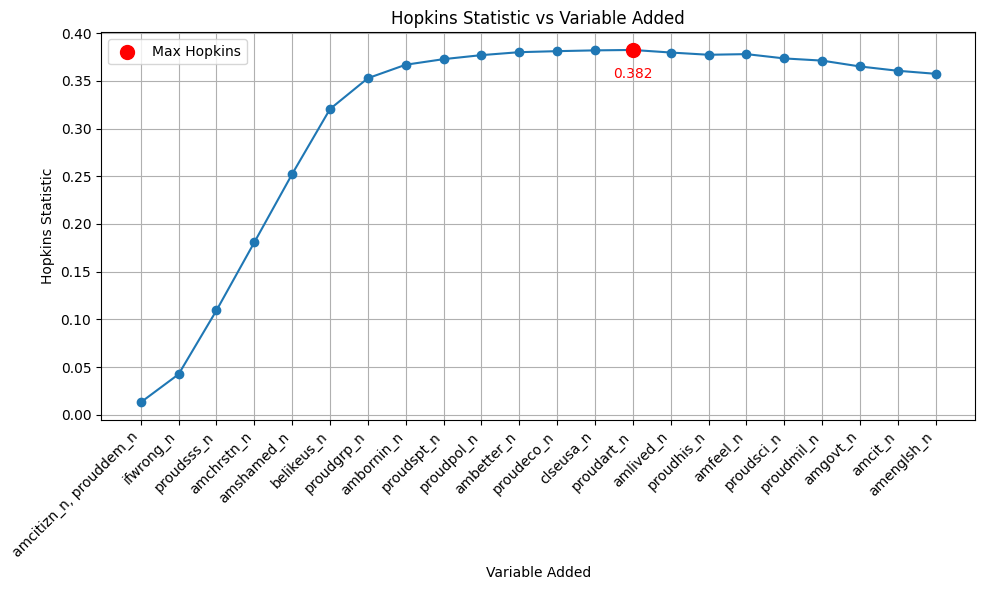

In [11]:
# add a line corresponding to the value of the configuration retained by the authors = hopkins_stat_short

plt.figure(figsize=(10, 6))
plt.plot(df_results["variable_added"], df_results["hopkins_stat"], marker='o', linestyle='-')

# Find index of max Hopkins stat
max_idx = df_results["hopkins_stat"].idxmax()
max_var = df_results.loc[max_idx, "variable_added"]
max_val = df_results.loc[max_idx, "hopkins_stat"]

# Highlight the max point
plt.scatter(max_idx, max_val, color='red', s=100, zorder=5, label='Max Hopkins')

# Annotate the max point
plt.annotate(f'{max_val:.3f}', 
             (max_idx, max_val), 
             textcoords="offset points", xytext=(0,-20), ha='center', color='red')

plt.xlabel("Variable Added")
plt.ylabel("Hopkins Statistic")
plt.title("Hopkins Statistic vs Variable Added")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

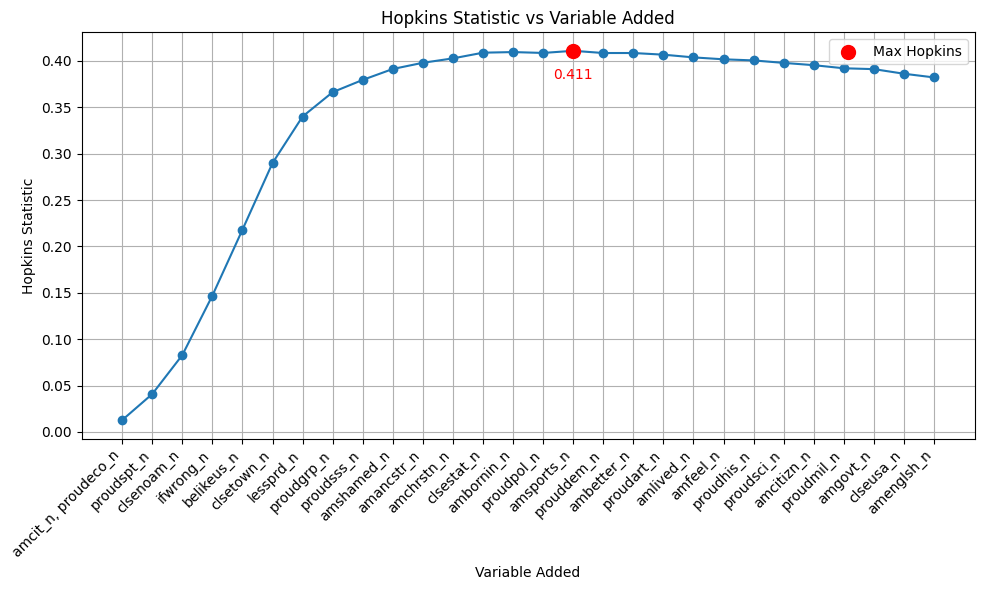

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_results["variable_added"], df_results["hopkins_stat"], marker='o', linestyle='-')

# Find index of max Hopkins stat
max_idx = df_results["hopkins_stat"].idxmax()
max_var = df_results.loc[max_idx, "variable_added"]
max_val = df_results.loc[max_idx, "hopkins_stat"]

# Highlight the max point
plt.scatter(max_idx, max_val, color='red', s=100, zorder=5, label='Max Hopkins')

# Annotate the max point
plt.annotate(f'{max_val:.3f}', 
             (max_idx, max_val), 
             textcoords="offset points", xytext=(0,-20), ha='center', color='red')

plt.xlabel("Variable Added")
plt.ylabel("Hopkins Statistic")
plt.title("Hopkins Statistic vs Variable Added")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()